<a href="https://colab.research.google.com/github/SomeiLam/api-docs-ai-agent-colab/blob/main/Copy_of_sikka_apis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Summary

This Colab notebook implements a full‑stack, retrieval‑augmented code generation pipeline for building payment integration apps using Sikka APIs. It breaks the user’s high‑level request into discrete AI agents that each handle one piece of the workflow:

1. **Query Optimizer**  
   Normalizes and scopes the user’s message, detects tech stacks, and produces structured prompts.  
2. **API‑Docs Generator**  
   Retrieves relevant API reference snippets via FAISS and generates detailed endpoint documentation (base URL, version, headers, parameters, sample requests/responses).  
3. **Frontend Code Generator**  
   Produces React (or Next.js) components for the checkout UI, wiring up form state, loading, and error handling.  
4. **Backend Code Generator**  
   Generates Node.js + Express routes that obtain/refresh the Sikka `request_key`, save cards, and process payments.  
5. **Code Evaluator & Refinement**  
   Splits evaluation into frontend/backend reviewers, collects issues and suggestions, and applies fixes via a reusable refinement agent.  
6. **Documentation Formatter**  
   Assembles the optimized query, tech stack, API docs, frontend code, and backend code into a polished Markdown deliverable.  
7. **Follow‑up QA**  
   Maintains conversational memory and combines the final document with FAISS‑retrieved context to answer user follow‑up questions without re‑running the full pipeline.

Together, these agents demonstrate how to orchestrate multiple LLM calls in Colab—leveraging CrewAI, FAISS, and OpenAI’s GPT models—to automate everything from requirements analysis to production‑ready code and documentation.

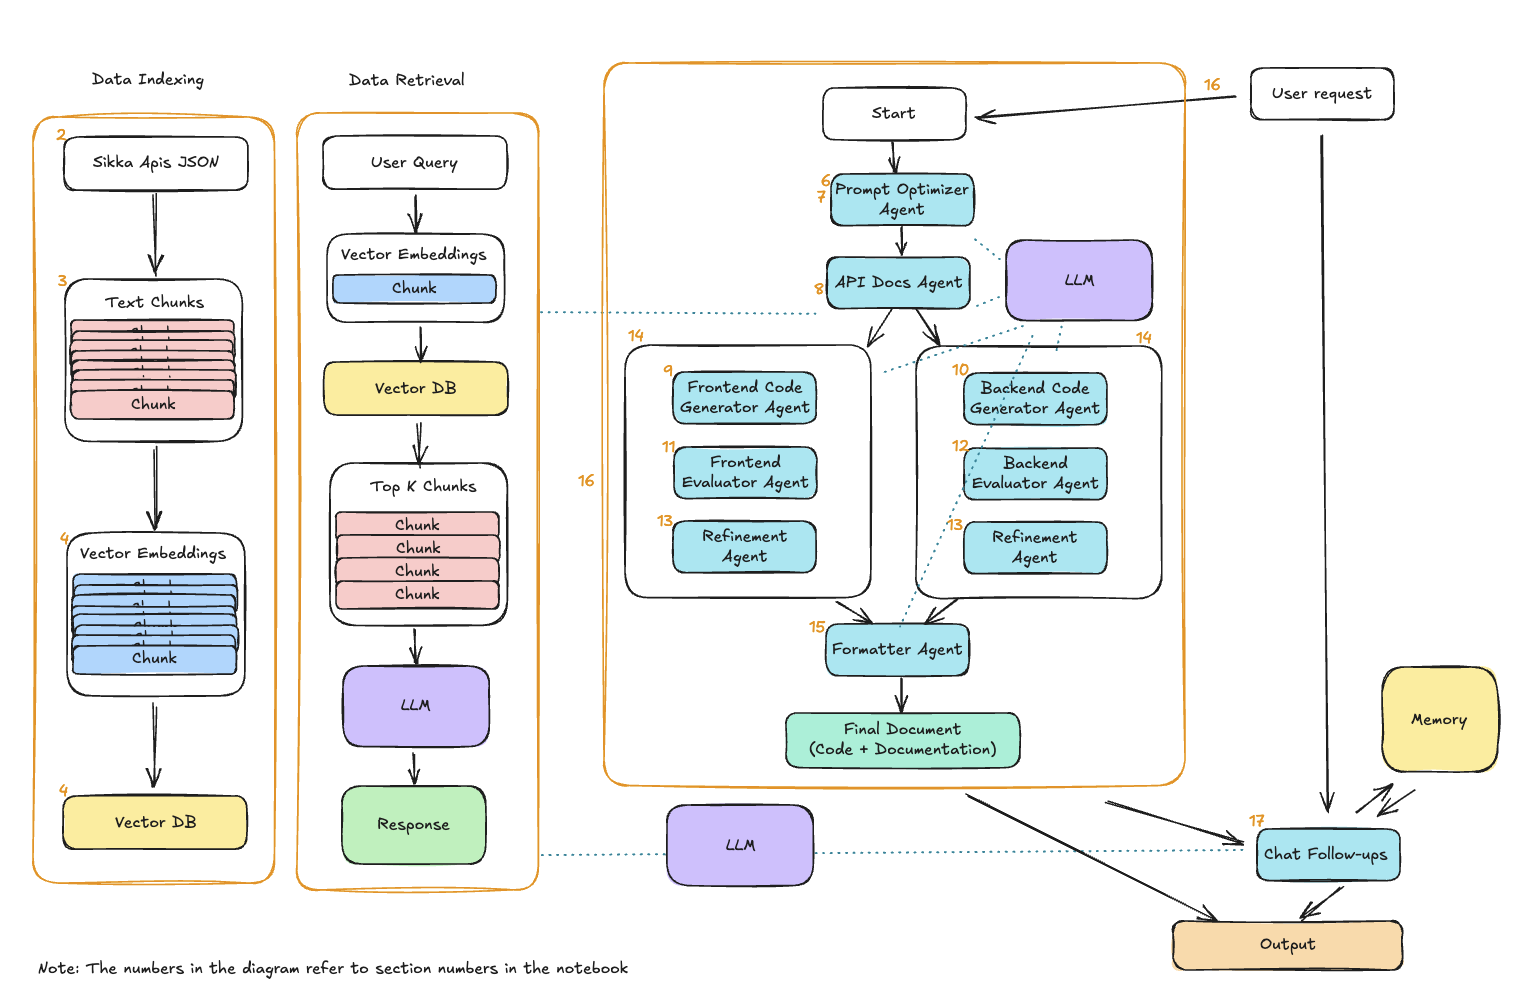

---

### Notebook Installation

Before running any cells, install and pin your dependencies for a reproducible environment. In a new Colab cell, run
```
# Install core libraries for FAISS vector search, OpenAI API access, tokenization, agent orchestration, and retrieval workflows
!pip install --upgrade --no-cache-dir \
    faiss-cpu    # vector similarity search engine for nearest‑neighbor lookup  
    openai       # official OpenAI Python client for embeddings and chat completions  
    tiktoken     # high‑speed tokenizer compatible with OpenAI models  
    langchain    # framework for building retrieval‑augmented LLM applications  
    crewai       # library for coordinating multi‑agent AI workflows  
```

In [ ]:
!pip install --upgrade --no-cache-dir faiss-cpu openai tiktoken langchain crewai


---
### **1. Environment Setup & Key Imports**

This initialization cell prepares our Colab environment by:

- **Importing standard libraries**  
  - `os`, `pathlib` for file and environment management  
  - `json`, `pickle` for data serialization  
  - `textwrap` for text formatting  
  - `getpass` for optional secure input  
  - `typing` helpers (`List`, `Dict`) for clearer function signatures  

- **Importing core third‑party packages**  
  - `numpy` for numerical arrays  
  - `faiss` for fast similarity search over embeddings  
  - `tiktoken` for tokenizing inputs to OpenAI models  
  - `openai` for interacting with OpenAI’s embeddings and chat APIs  

- **Loading your OpenAI API key securely**  
  - Go to the Colab toolbar, click the **lock icon (Secrets pane)** on the left, choose **“Add secret”**, enter **`OPENAI_API_KEY`** as the name and paste your key as the value.  
  - This makes it available via `from google.colab import userdata` and `userdata.get("OPENAI_API_KEY")`.  

- **Setting the embedding model**  
  - `EMBED_MODEL = "text-embedding-3-small"` will be used for all vectorization calls.  

With these steps, the notebook can safely call the OpenAI and FAISS-based vector search functions without exposing your secret in plain code.


In [ ]:
import os
import json
import pathlib
import textwrap
import pickle
import getpass
from typing import List, Dict

import numpy as np
import faiss
import tiktoken
import openai

from google.colab import userdata

# Load the OpenAI API key from Colab secrets and set it as an environment variable
api_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

# Name of the embedding model to use for vectorization
EMBED_MODEL = "text-embedding-3-small"


---
### **2. Extract Structured Documentation**

This cell defines and runs a **`collect_docs`** function to extract structured documentation from the Postman collection JSON:

1. **Loading & Parsing**  
   - Reads `sikka-apis.json` into `root`.

2. **Depth‑First Traversal**  
   - Uses a stack to walk through nested dicts and lists.
   - Tracks the “path” (e.g. `Sikka API v4 › Authorization › Generate request_key`) to locate each item.

3. **Extracting Snippets**  
   - Gathers:
     - Plain-text `description` fields.
     - Request-level docs & raw JSON bodies.
     - Sample responses (`response.body`).
     - Inline scripts (`event → script.exec`).

4. **Output Format**  
   - Returns a list of dicts, each with:
     - `"content"`: a markdown string combining the snippets.
     - `"path"`: the hierarchical breadcrumb.

5. **Role in Pipeline**  
   - These extracted docs become the **knowledge base** for FAISS indexing and subsequent retrieval‑augmented LLM prompts.


In [ ]:
# Load and parse the Postman collection JSON file
FILE = pathlib.Path("sikka-apis.json")   # Path to the raw API spec
root = json.loads(FILE.read_text())      # Parse JSON into Python object

def collect_docs(node):
    """
    Traverse a Postman collection (dicts & lists) depth‑first, extracting:
      - Resource & request descriptions
      - Endpoint (METHOD + full URL)
      - Headers
      - Request body
      - Response samples
      - Example scripts

    Returns a list of {"content": markdown, "path": hierarchical name}.
    """
    stack, out = [([], node)], []

    while stack:
        path, cur = stack.pop()

        if isinstance(cur, dict):
            name     = cur.get("name") or "<no‑name>"
            new_path = path + [name]
            buckets  = []

            # 1) Resource‑level description
            if desc := cur.get("description"):
                buckets.append("**Description:**\n" + desc.strip())

            # 2) Request block
            req    = cur.get("request", {}) or {}
            method = req.get("method", "").upper()

            # Build the full URL (either raw or protocol + host + path)
            raw_url = req.get("url", {}).get("raw")
            if not raw_url and isinstance(req.get("url"), dict):
                u = req["url"]
                host = ".".join(u.get("host", []))
                path = "/".join(u.get("path", []))
                raw_url = f"{u.get('protocol','https')}://{host}/{path}"

            # 2a) Request‑level description
            if rdesc := req.get("description"):
                buckets.append("**Request Description:**\n" + rdesc.strip())

            # 2b) Endpoint line
            if method and raw_url:
                buckets.append(f"**Endpoint:** `{method} {raw_url}`")

            # 2c) Headers
            if hdrs := req.get("header"):
                lines = [
                    f"- `{h.get('key')}`: `{h.get('value')}`"
                    for h in hdrs
                ]
                buckets.append("**Headers:**\n" + "\n".join(lines))

            # 2d) Request body
            if raw_body := req.get("body", {}).get("raw"):
                buckets.append(
                    "**Request Body:**\n```json\n"
                    + raw_body[:2000]
                    + "\n```"
                )

            # 3) Response samples
            for resp in cur.get("response", []):
                status = resp.get("code") or resp.get("status", "")
                if body := resp.get("body"):
                    label = f"**Response ({status})**" if status else "**Response**"
                    buckets.append(
                        f"{label}:\n```json\n"
                        + body[:2000]
                        + "\n```"
                    )

            # 4) Event scripts (tests/examples)
            for ev in cur.get("event", []):
                exec_lines = ev.get("script", {}).get("exec") or []
                if exec_lines:
                    buckets.append(
                        "**Example Script:**\n```javascript\n"
                        + "\n".join(exec_lines)[:2000]
                        + "\n```"
                    )

            # If we have any extracted pieces, save them
            if buckets:
                out.append({
                    "content": (
                        f"# {' › '.join(new_path)}\n\n"
                        + "\n\n".join(buckets)
                    ),
                    "path": " › ".join(new_path)
                })

            # Recurse into child items
            for child in cur.get("item", []):
                stack.append((new_path, child))

        elif isinstance(cur, list):
            for itm in cur:
                stack.append((path, itm))

    return out


# Run the collector and show a quick summary
docs = collect_docs(root)
print("Total docs captured:", len(docs))


Total docs captured: 392


---
### **3. Documentation Chunking for Embedding**

This cell configures and demonstrates how to split raw documentation entries into manageable chunks for embedding and retrieval:

- **Importing text splitters**  
  - `RecursiveCharacterTextSplitter` (general‑purpose, prioritizes paragraphs and lines)  
  - `MarkdownTextSplitter` (optional, preserves markdown headings and fenced code)  

- **Configuring the splitter**  
  - `chunk_size=3000` characters target  
  - `chunk_overlap=150` characters overlap to boost retrieval recall  
  - `separators=["\n\n", "\n", " ", ""]` to split on paragraphs, then lines, then words  

- **Defining `smart_chunk_docs(docs)`**  
  - Iterates over each doc entry  
  - Uses the splitter to break `content` into `pieces`  
  - Attaches metadata `{ "path": ..., "chunk": index }` to each piece  

- **Demonstration**  
  - `docs_raw = collect_docs(root)` gathers ~392 full entries  
  - `docs_chunk = smart_chunk_docs(docs_raw)` produces ~517 chunks  
  - Prints before/after counts and an example metadata dict  

- **Role in Pipeline**  
  Splitting ensures each chunk is small enough (<3000 chars) for embedding models while maintaining context, improving FAISS similarity search for downstream prompt construction.  


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownTextSplitter

# NOTE: We’re not using smart_chunk_docs here because our collected docs
# are already well‑structured and sized appropriately for embedding.
# In general, for unstructured text, you could split into ~3k‑char chunks:
# splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=150, separators=["\n\n","\n"," ",""])
# or use MarkdownTextSplitter to preserve headings/code fences.
#
# But for our Postman‑derived docs, each entry is its own “chunk” and passed
# directly to the embedder.

def smart_chunk_docs(docs):
    """
    (Optional) Split large docs into overlapping sub‑chunks for retrieval.
    Not used in this pipeline since each doc entry is already appropriately sized.
    """
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=3000,
        chunk_overlap=150,
        separators=["\n\n", "\n", " ", ""]
    )
    out = []
    for d in docs:
        pieces = splitter.split_text(d["content"])
        meta   = d.get("meta") or {"path": d.get("path", "")}
        for i, part in enumerate(pieces):
            out.append({"content": part, "meta": {**meta, "chunk": i}})
    return out

# Use the raw docs directly for embedding/retrieval:
docs_raw = collect_docs(root)         # e.g. 392 entries
print("Docs to index:", len(docs_raw))
docs_chunk = smart_chunk_docs(docs_raw)

Docs to index: 392


---
### **4. FAISS Index Construction**

This cell builds our FAISS vector index by embedding each documentation chunk:

- **Client setup**  
  - Uses the `OpenAI` client with your `api_key` for embedding calls.  

- **Defining `embed_texts`**  
  - Wrapper around the new OpenAI ≥1.0.0 SDK  
  - Takes a list of strings plus an embedding model name  
  - Returns a list of float vectors in the same order as inputs  

- **Batch embedding loop**  
  - Splits `docs_raw` into batches of size 96  
  - Calls `embed_texts` for each batch to avoid rate or size limits  
  - Accumulates all embeddings into `vecs`  

- **FAISS index creation**  
  - Converts `vecs` to a NumPy array of type `float32`  
  - Initializes an inner‑product index (`IndexFlatIP`) matching the embedding dimension  
  - Adds all vectors to the index for fast similarity search  

- **Verification**  
  - Prints the total number of vectors indexed (`index.ntotal`)  

This prepares the FAISS index for nearest‑neighbor retrieval in downstream prompt construction.


In [ ]:
from openai import OpenAI
client = OpenAI(api_key=api_key)

def embed_texts(texts: list[str], model: str = EMBED_MODEL) -> list[list[float]]:
    """
    Returns embeddings for a list of texts using the OpenAI SDK client.
    """
    resp = client.embeddings.create(model=model, input=texts)
    return [e.embedding for e in resp.data]

# Batch‑embed all raw document chunks and build a FAISS index
vecs, BATCH = [], 96
for i in range(0, len(docs_raw), BATCH):
    batch = [d["content"] for d in docs_raw[i:i+BATCH]]
    vecs.extend(embed_texts(batch))

# Convert to NumPy float32 array and index with inner‑product similarity
vecs = np.asarray(vecs, dtype="float32")
index = faiss.IndexFlatIP(vecs.shape[1])
index.add(vecs)

print("FAISS index size:", index.ntotal)


FAISS index size: 392


---
### **5. Retrieval‑Only Helper (`ask_sikka`)**

This helper function lets you query the raw Sikka API documentation “knowledge base” without triggering the full pipeline. It:

- **Embeds the user query**  
  - Calls `embed_texts` to get the query vector  
- **Performs a FAISS lookup**  
  - Retrieves the top `k` most similar document chunks  
- **Builds a minimal LLM prompt**  
  - System instruction: “Answer only from context; say ‘Not found’ otherwise.”  
  - User message: includes the retrieved context and the original question  
- **Invokes the chat model**  
  - Uses `gpt-4o-mini` and returns the assistant’s text response  

You can call `ask_sikka("your question")` to test how well the vector store + LLM answers direct questions from the docs.


In [ ]:
def ask_sikka(
    query: str,
    k: int = 4,
    model: str = "gpt-4o-mini",
    debug: bool = False
) -> str:
    """
    Retrieve the top‑k relevant chunks for `query` from your FAISS index,
    then ask the chat model to answer using ONLY that context.

    Args:
      query: The user’s question.
      k: Number of chunks to retrieve.
      model: Which chat model to use.
      debug: If True, print each retrieved chunk with its score.

    Returns:
      The assistant’s reply (stripped of whitespace).
    """
    # 1) Embed the query
    embedding: List[float] = embed_texts([query])[0]

    # 2) FAISS search for top-k similar docs
    distances, indices = index.search(
        np.array([embedding], dtype="float32"),
        k
    )

    # 3) Debug output of retrieved snippets
    if debug:
        for dist, idx in zip(distances[0], indices[0]):
            snippet = docs_chunk[idx]["content"]
            print(f"[DEBUG] Chunk {idx} (score {dist:.3f}):\n{snippet}\n")

    # 4) Build the context string
    context = "\n\n---\n\n".join(
        docs_chunk[i]["content"] for i in indices[0]
    )

    # 5) Ask the model with a strict “only-from-context” instruction
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "Answer **only** from the context below; if it's not in the context, reply 'Not found'."
            },
            {
                "role": "user",
                "content": f"Context:\n{context}\n\nQuestion: {query}"
            }
        ]
    )

    # 6) Return the assistant’s reply
    return response.choices[0].message.content.strip()


# ── Example Usage ─────────────────────────────────────────────────────

if __name__ == "__main__":
    for q in [
        "For the POST /v2/payment/store-card endpoint, list its headers and parameters.",
        "What is the endpoint for save a card?"
    ]:
        print(f"Q: {q}")
        print("A:", ask_sikka(q))
        # print("A:", ask_sikka(q, debug=True))
        print("-" * 40)

Q: For the POST /v2/payment/store-card endpoint, list its headers and parameters.
A: **Headers:**
- `Content-Type`: `application/json`

**Parameters:**
- `request_key`: "request_key - mandatory"
- `patient_id`: "patient_id - mandatory"
- `guarantor_id`: "guarantor_id - mandatory"
- `practice_id`: "practice_id - mandatory"
- `cust_id`: "cust_id - mandatory"
- `provider_id`: "provider_id - optional"
- `name`: "name - mandatory"
- `zipcode`: "zipcode - mandatory"
- `billing_id`: "billing_id - mandatory"
- `is_update_default`: "true - mandatory"
- `is_default`: "true/false"
----------------------------------------
Q: What is the endpoint for save a card?
A: The endpoint for saving a card is `POST https://api.sikkasoft.com/v2/payment/store_card`.
----------------------------------------


---
### **6. Optimizer Template Definition**

This cell defines the `OPTIMIZER_TEMPLATE` string, which primes the Query Optimizer Agent to:

- **Validate Scope**  
  - Checks if the user’s request pertains to building or integrating with Sikka APIs.  
  - If out‑of‑scope, instructs the agent to output a minimal JSON and stop.

- **Detect Tech Stack**  
  - Parses the user message for frontend frameworks/languages (e.g. React, Next.js, TypeScript).  
  - Parses for backend frameworks/languages (e.g. Node.js, Express, Python, Flask).  
  - Falls back to “React + JavaScript” front end and “Node.js + Express + JavaScript” back end if none are detected.

- **Rewrite & Decompose**  
  - Produces a one‑sentence `optimized_query` restating the user’s goal.  
  - Generates **four** specialized prompts under `prompts` for downstream agents:
    1. **api_docs** – Instructs how to identify and document all required Sikka endpoints, including full base URLs, auth flow, headers, parameters, and examples.  
    2. **frontend** – Guides the UI agent to build the frontend with the detected framework, integrate the endpoints, and handle state/loading/errors.  
    3. **backend** – Directs the backend agent to implement routes in the detected framework, handle `request_key` acquisition/refresh, and call the endpoints returning JSON.  
    4. **formatter** – Tells the formatter agent to assemble everything into a single Markdown document with specified headings.

- **Define JSON Output Schema**  
  - Specifies the exact structure the optimizer must return, containing:  
    ```json
    {
      "scope_ok": true|false,
      "optimized_query": "...",
      "tech_stack": {"frontend": "...", "backend": "..."},
      "prompts": {
        "api_docs": "...",
        "frontend": "...",
        "backend": "...",
        "formatter": "..."
      }
    }
    ```  
  - Emphasizes “no extra keys” to ensure downstream agents receive a strictly consistent payload.


In [ ]:
# Prompt template  ─────────────────────────────────────────────

OPTIMIZER_TEMPLATE = """
You are the Query Optimizer for a multi‑agent system that builds full‑stack apps with Sikka APIs.
**Important:** Base **all** details strictly on the provided knowledge base. Do **not** hallucinate or invent any endpoints, parameters, or sample data.

USER_MESSAGE:
\"\"\"{user_message}\"\"\"

Step 1: Scope
• If the message is not about building or integrating Sikka APIs, output exactly:
  {{ "scope_ok": false, "reason": "short explanation" }}
  and STOP.

Step 2: Tech stack
• Detect any frontend frameworks/languages (e.g. React, Next.js, TypeScript).
• Detect any backend frameworks/languages (e.g. Node.js, Express, Python, Flask).
• If none are found, default to “React + JavaScript” front end and “Node.js + Express + JavaScript” back end.

Step 3: Rewrite & decompose
• Produce one sentence `optimized_query` restating the goal.
• Produce **four** prompts under `prompts` with these keys:

  1. **api_docs**
     – Identify all required Sikka endpoints for `optimized_query`.
     – For each endpoint, specify the **full base URL including the correct version**, the path, and HTTP method. They must **strictly** based on the provided knowledge base.
     – Document the authentication flow (request_key lifecycle).
     – List required headers and body/query parameters per endpoint.
     – Include a sample request and a sample response for each endpoint.

  2. **frontend**
     – Build the UI using the detected frontend framework.
     – Call the endpoints identified in `api_docs`.
     – Specify component/file names.
     – Handle form state, loading indicators, and error displays.

  3. **backend**
     – Implement server routes using the detected backend framework.
     – Include code to obtain and refresh the request_key.
     – Show how to call each Sikka endpoint and return JSON responses.

  4. **formatter**
     – Assemble **all** outputs into a single Markdown document.
     – Include headings for Overview, API Documentation, Frontend Code, and Backend Code.

Step 4: Output exactly this JSON (no extra keys):

```json
{{
  "scope_ok": true,
  "optimized_query": "<one‑sentence restatement>",
  "tech_stack": {{
    "frontend": "<detected or default stack>",
    "backend":  "<detected or default stack>"
  }},
  "prompts": {{
    "api_docs":  "<instruction containing all required elements>",
    "frontend":  "<instruction containing all required elements>",
    "backend":   "<instruction containing all required elements>",
    "formatter": "<instruction containing all required elements>"
  }}
}}

"""


---
### **7. Query Optimizer Agent Setup**

This cell sets up and runs the **Query Optimizer** agent:

- **Imports & Client Setup**  
  - `Agent`, `Task`, `Crew` from `crewai` to define and execute tasks.  
  - `re` for stripping Markdown fences from the LLM output.  
  - `OpenAI` client (v1 SDK) initialized with the Colab secret.  

- **Agent Definition**  
  - Creates `optimizer_agent` with role, goal, backstory, and LLM spec (`gpt-4o-mini`).  
  - Defines a reusable `opt_task` template pointing at `OPTIMIZER_TEMPLATE`.  

- **Helper Function `run_optimizer`**  
  1. **Prompt Formatting**  
     - Injects the `user_message` into the `OPTIMIZER_TEMPLATE`.  
  2. **Task Execution**  
     - Constructs and runs a one‑task `Crew` to invoke the optimizer.  
  3. **Output Cleaning**  
     - Strips any ```json fences.  
  4. **JSON Parsing**  
     - Returns a Python `dict` matching the optimizer’s schema.  

- **Example Invocation**  
  - Demonstrates using `run_optimizer(...)` to validate/normalize a sample user request.


In [ ]:
import os
import json
import re
from crewai import Agent, Task, Crew
from openai import OpenAI
from google.colab import userdata

# Load API key from Colab secrets and initialize OpenAI client
api_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key
client = OpenAI(api_key=api_key)

# 1) Define the Query Optimizer agent
optimizer_agent = Agent(
    role="Query Optimizer",
    goal="Validate scope and normalize user queries about Sikka APIs",
    backstory="Expert in Sikka’s API portfolio and software design.",
    allow_delegation=False,
    llm="gpt-4o-mini"
)

# 2) Prepare the optimization task template
opt_task = Task(
    agent=optimizer_agent,
    description=OPTIMIZER_TEMPLATE,    # will .format(user_message=…) later
    expected_output="JSON exactly matching the schema above."
)

def run_optimizer(user_message: str) -> dict:
    """
    Execute the optimizer on `user_message` and parse its JSON output.
    """
    # a) Inject the user's message into the template
    prompt = OPTIMIZER_TEMPLATE.format(user_message=user_message)

    # b) Create & run the task
    task = Task(
        agent=optimizer_agent,
        description=prompt,
        expected_output="JSON exactly matching the schema above."
    )
    crew_output = Crew(agents=[optimizer_agent], tasks=[task], verbose=False).kickoff()

    # c) Extract raw LLM response
    raw = crew_output.tasks_output[0].raw

    # d) Strip any ``` or ```json fences
    cleaned = "\n".join(
        line for line in raw.splitlines()
        if not re.match(r"^```(?:json)?\s*$", line)
    ).strip()

    # e) Parse and return as a dict
    return json.loads(cleaned)

# Example: Using the Query Optimizer on a user request
if __name__ == "__main__":
    # 1) Define the user's natural‑language request
    user_request = (
        "I want a React checkout page that saves a patient's card"
    )

    # 2) Print the original request string
    print("=== User Request ===")
    print(user_request, "\n")

    # 3) Run the optimizer to normalize & decompose the request
    optimized_output = run_optimizer(user_request)

    # 4) Pretty‑print the optimized result for clarity
    import json
    print("=== Optimizer Result ===")
    print(json.dumps(optimized_output, indent=2))


=== User Request ===
I want a React checkout page that saves a patient's card 

=== Optimizer Result ===
{
  "scope_ok": true,
  "optimized_query": "Create a React checkout page that securely saves a patient's card information using Sikka APIs.",
  "tech_stack": {
    "frontend": "React + JavaScript",
    "backend": "Node.js + Express + JavaScript"
  },
  "prompts": {
    "api_docs": "Identify all required Sikka endpoints for saving a patient's card information. The main endpoint to consider is 'Create Payment Method'. The correct version is v1. The full base URL is: https://api.sikkaapp.com/v1/payment-methods. The HTTP method is POST. The authentication flow involves using a request key that should be included in headers for authentication. Required headers include 'Authorization: Bearer {request_key}' and 'Content-Type: application/json'. The body should include parameters like 'patient_id', 'card_number', 'expiry_date', and 'cvv'. Sample request: {\"patient_id\": \"12345\", \"card_n

---
### **8. API‑Docs Generator Agent Setup**

This cell sets up and runs the “API‑Docs Generator” agent:

- **Imports**  
  - Pulls in `Agent`, `Task`, and `Crew` from `crewai` to define and execute the agent.  
  - Imports `numpy` for array handling in the FAISS search.

- **Context Retriever**  
  - `retrieve_api_context(query, k)` embeds the user’s query, searches the FAISS index for the top‑k most relevant chunks, and concatenates them as a context string.

- **Agent Definition**  
  - `api_doc_agent` is configured to generate detailed Markdown API documentation for Sikka endpoints.

- **Runner Function**  
  - `run_api_docs_step(opt_out)`  
    1. Checks if the user request is in‑scope.  
    2. Builds a prompt combining the optimizer’s `api_docs` instruction with FAISS‑retrieved context.  
    3. Runs a single‑task Crew to get the Markdown documentation.  
    4. Returns the raw Markdown response for downstream use.


In [ ]:
from crewai import Agent, Task, Crew   # Core classes to define and run our agent
import numpy as np                    # Numerical library used by FAISS search

def retrieve_api_context(query: str, k: int = 6) -> str:
    """
    Embed the query, perform a FAISS similarity search,
    and join the top-k document chunks into one context string.
    """
    q_emb = embed_texts([query])[0]                      # 1) Create embedding for the query
    _, idx = index.search(np.array([q_emb], dtype="float32"), k)  # 2) Search FAISS index
    # 3) Concatenate the retrieved passages with separators
    return "\n\n---\n\n".join(docs[i]["content"] for i in idx[0])

# Define the API‑Docs Generator agent
api_doc_agent = Agent(
    role             = "API Docs Generator",    # Agent’s persona
    goal             = "Produce detailed API documentation for the endpoints needed",
    backstory        = "Specialist in Sikka API reference docs.",
    allow_delegation = False,
    llm              = "gpt-4o-mini"
)

def run_api_docs_step(opt_out: dict) -> str:
    """
    Build and run a single‑task Crew to generate Markdown API docs.
    Returns the raw Markdown or an out‑of‑scope notice.
    """
    # 1) Scope guard: skip if optimizer said out‑of‑scope
    if not opt_out.get("scope_ok", False):
        return "⚠️ Out of scope. No API docs generated."

    # 2) Prepare prompt: instruction + retrieved context
    instr  = opt_out["prompts"]["api_docs"]                   # Optimizer’s API‑docs instruction
    ctx    = retrieve_api_context(opt_out["optimized_query"]) # FAISS context for the optimized query
    prompt = f"{instr}\n\nHere is the relevant API context:\n{ctx}\n**Important:** Base **all** details strictly on the provided knowledge base. Do **not** hallucinate or invent any endpoints, parameters, or sample data."  # Complete LLM prompt

    # 3) Define and run the Crew task
    task = Task(
        agent           = api_doc_agent,
        description     = prompt,
        expected_output = (
            "A Markdown document covering ONLY the Sikka endpoints, "
            "authentication flow, headers, parameters, and sample calls."
        )
    )
    crew_output = Crew(
        agents=[api_doc_agent],
        tasks=[task],
        verbose=False
    ).kickoff()  # Execute the task

    # 4) Extract and return the raw Markdown response
    return crew_output.tasks_output[0].raw


---
### **9. Frontend Code Generator Agent Setup**

This cell defines and runs the “Frontend Code Generator” agent:

- **Agent Definition**  
  - Creates `frontend_agent` with a React/Next.js focus and clear UI/UX expertise.

- **Runner Function (`run_frontend_step`)**  
  1. **Scope Guard:** Returns early if the optimizer flagged the request as out‑of‑scope.  
  2. **Prompt Assembly:** Combines the optimizer’s “frontend” instruction with the previously generated API docs.  
  3. **Crew Execution:** Spins up a one‑task Crew to generate the React/Next.js code.  
  4. **Output Extraction:** Returns the raw code string for use by subsequent steps.


In [ ]:
from crewai import Agent, Task, Crew

# 1) Define the Frontend Code Generator agent
frontend_agent = Agent(
    role             = "Frontend Code Generator",              # Agent’s persona
    goal             = "Produce React/Next.js frontend code for the checkout flow",
    backstory        = "Expert in building modern React applications and UI/UX best practices.",
    allow_delegation = False,
    llm              = "gpt-4o-mini"                         # Model to drive this agent
)

def run_frontend_step(opt_out: dict, api_docs_md: str) -> str:
    """
    Generate (or regenerate) the React/Next.js frontend code.

    Args:
      opt_out     – Output dict from run_optimizer(...)
      api_docs_md – Markdown API docs from run_api_docs_step(...)

    Returns:
      Raw code string for the frontend application.
    """
    # 1) Out‑of‑scope guard
    if not opt_out.get("scope_ok", False):
        return "⚠️ Out of scope. No frontend code generated."

    # 2) Build the prompt using the optimizer’s 'frontend' instruction
    instr  = opt_out["prompts"]["frontend"]                   # Instruction text
    prompt = (
        f"{instr}\n\nHere are the API docs you should integrate with:\n"
        f"{api_docs_md}"
    )

    # 3) Launch a one‑task Crew to generate the code
    task = Task(
        agent           = frontend_agent,                     # Which agent to run
        description     = prompt,                             # Full LLM prompt
        expected_output = (
            "A React (or Next.js) component/file structure & code for the checkout UI, "
            "handling card input, form state, loading, and error display."
        )
    )
    crew_output = Crew(
        agents=[frontend_agent],
        tasks =[task],
        verbose=False
    ).kickoff()

    # 4) Extract and return the raw code string
    return crew_output.tasks_output[0].raw


---
### **10. Backend Code Generator Agent Setup**

This cell defines and runs the “Backend Code Generator” agent:

- **Agent Definition**  
  - Creates `backend_agent` specialized in Node.js/Express APIs with a focus on security and scalability.

- **Runner Function (`run_backend_step`)**  
  1. **Scope Guard:** Checks the optimizer output; returns early if out‑of‑scope.  
  2. **Prompt Assembly:** Combines the optimizer’s “backend” instruction with the generated API docs.  
  3. **Crew Execution:** Launches a one‑task Crew to generate the Express server code.  
  4. **Output Extraction:** Returns the raw backend code string for downstream use.  


In [ ]:
from crewai import Agent, Task, Crew

# 1) Define the Backend Code Generator agent
backend_agent = Agent(
    role             = "Backend Code Generator",                 # Agent’s persona
    goal             = "Produce Node.js/Express backend code for the checkout flow",
    backstory        = "Expert in building secure and scalable Express APIs.",
    allow_delegation = False,
    llm              = "gpt-4o-mini"                          # Model to drive this agent
)

def run_backend_step(opt_out: dict, api_docs_md: str) -> str:
    """
    Generate the Node.js + Express backend code.

    Args:
      opt_out     – dict from run_optimizer(...)
      api_docs_md – Markdown API docs from run_api_docs_step(...)

    Returns:
      Raw code string for the backend server.
    """
    # 1) Out‑of‑scope guard
    if not opt_out.get("scope_ok", False):
        return "⚠️ Out of scope. No backend code generated."

    # 2) Build the prompt using the optimizer’s 'backend' instruction
    instr  = opt_out["prompts"]["backend"]                      # Instruction text
    prompt = (
        f"{instr}\n\nHere are the API docs you should integrate with:\n"
        f"{api_docs_md}"
    )

    # 3) Launch a one‑task Crew to generate the code
    task = Task(
        agent           = backend_agent,                         # Which agent to run
        description     = prompt,                                # Full LLM prompt
        expected_output = (
            "Node.js + Express server code with routes to handle saving cards "
            "and processing payments using the provided Sikka endpoints."
        )
    )
    crew_output = Crew(
        agents=[backend_agent],
        tasks =[task],
        verbose=False
    ).kickoff()

    # 4) Extract and return the raw code string
    return crew_output.tasks_output[0].raw


---
### **11. Frontend Code Evaluator Agent Setup**

This cell defines the **Frontend Code Evaluator** agent and its runner function:

- **Agent Definition**  
  - `frontend_evaluator_agent` is a specialist in React/Next.js best practices and front‑end security.  
  - Its sole responsibility is to detect **critical** correctness or security issues.

- **Runner Helper (`run_frontend_eval`)**  
  1. **Scope Check:** Returns empty report if the request is out of scope.  
  2. **Prompt Construction:** Crafts a strict JSON‑only prompt asking for issues and suggestions.  
  3. **Crew Execution:** Runs a single‑task Crew to evaluate the provided code.  
  4. **Fence Stripping:** Removes any Markdown code fences from the LLM response.  
  5. **JSON Parsing:** Parses and returns the structured report for downstream use.


In [ ]:
import json
import re
from crewai import Agent, Task, Crew

# 1) Define the Frontend Evaluator agent
frontend_evaluator_agent = Agent(
    role             = "Frontend Code Evaluator",                  # Agent’s persona
    goal             = (
        "Inspect the React/Next.js frontend code and report *only* critical "
        "correctness or security issues in JSON format."
    ),
    backstory        = "Expert in React best practices, form validation, and front‑end security.",
    allow_delegation = False,
    llm              = "gpt-4o-mini"                               # Model to drive evaluation
)

# 2) Runner helper for frontend evaluation
def run_frontend_eval(opt_out: dict, frontend_code: str) -> dict:
    """
    Analyze frontend code for blocking issues and return a JSON report:
    {
      "issues": [ {"location":"frontend","line":int,"message":str,"severity":"critical"}, ... ],
      "suggestions": [ str, ... ]
    }
    """
    # Guard: skip evaluation if out-of-scope
    if not opt_out.get("scope_ok", False):
        return {"issues": [], "suggestions": []}

    # Build a strict JSON‑schema prompt
    prompt = f"""
You are a strict Bug‑Finder focused ONLY on frontend code.
Report *only* critical correctness or security issues in this JSON schema:

{{
  "issues": [
    {{
      "location": "frontend",
      "line": <integer>,
      "message": "<description>",
      "severity": "critical"
    }},
    ...
  ],
  "suggestions": [
    "<actionable improvement>",
    ...
  ]
}}

Here is the frontend code to evaluate:
{frontend_code}

Do NOT include any markdown or additional keys—output only the JSON.
""".strip()

    # Execute the evaluation task
    task = Task(
        agent           = frontend_evaluator_agent,
        description     = prompt,
        expected_output = "A JSON object with keys 'issues' and 'suggestions'."
    )
    out = Crew(agents=[frontend_evaluator_agent], tasks=[task], verbose=False).kickoff()
    raw = out.tasks_output[0].raw                                 # Raw LLM reply

    # Remove any ``` code fences
    cleaned = "\n".join(
        line for line in raw.splitlines()
        if not re.match(r"^```(?:\\w+)?\\s*$", line)
    ).strip()

    # Parse and return the JSON issue report
    return json.loads(cleaned)


---
### **12. Back Code Evaluator Agent Setup**

This cell defines the **Backend Code Evaluator** agent and its runner function:

- **Agent Definition**  
  - `backend_evaluator_agent` is an expert in Express API design, authentication flows, and security.  
  - Its sole responsibility is to identify **critical** correctness or security issues in backend code.

- **Runner Helper (`run_backend_eval`)**  
  1. **Scope Check:** Returns an empty report if the request is out of scope.  
  2. **Prompt Construction:** Builds a strict JSON‑only prompt asking for backend issues and suggestions.  
  3. **Crew Execution:** Runs a single‑task Crew to evaluate the provided backend code.  
  4. **Fence Stripping:** Removes any Markdown code fences from the LLM response.  
  5. **JSON Parsing:** Parses and returns the structured report for use in the refinement pipeline.


In [ ]:
import json
import re
from crewai import Agent, Task, Crew

# 1) Define the Backend Evaluator agent
backend_evaluator_agent = Agent(
    role             = "Backend Code Evaluator",                     # Agent persona
    goal             = (
        "Inspect the Node.js/Express backend code and report *only* critical "
        "correctness or security issues in JSON format."
    ),
    backstory        = "Expert in Express API design, authentication flows, and backend security.",
    allow_delegation = False,
    llm              = "gpt-4o-mini"                                 # Model for evaluation
)

# 2) Runner helper for backend evaluation
def run_backend_eval(opt_out: dict, backend_code: str) -> dict:
    """
    Analyze backend code for blocking issues.
    Returns a dict with:
      {
        "issues": [
          {"location":"backend","line":int,"message":str,"severity":"critical"},
          ...
        ],
        "suggestions": [
          str, ...
        ]
      }
    """
    # Guard: skip if out-of-scope
    if not opt_out.get("scope_ok", False):
        return {"issues": [], "suggestions": []}

    # Build a strict JSON‑schema prompt
    prompt = f"""
You are a strict Bug‑Finder focused ONLY on backend code.
Report *only* critical correctness or security issues in this JSON schema:

{{
  "issues": [
    {{
      "location": "backend",
      "line": <integer>,
      "message": "<description>",
      "severity": "critical"
    }},
    ...
  ],
  "suggestions": [
    "<actionable improvement>",
    ...
  ]
}}

Here is the backend code to evaluate:
{backend_code}

Do NOT include any markdown or additional keys—output only the JSON.
""".strip()

    # Execute the evaluation task
    task = Task(
        agent           = backend_evaluator_agent,
        description     = prompt,
        expected_output = "A JSON object with keys 'issues' and 'suggestions'."
    )
    out = Crew(agents=[backend_evaluator_agent], tasks=[task], verbose=False).kickoff()
    raw = out.tasks_output[0].raw                                  # Raw LLM reply

    # Remove any ``` code fences
    cleaned = "\n".join(
        line for line in raw.splitlines()
        if not re.match(r"^```(?:\\w+)?\\s*$", line)
    ).strip()

    # Parse and return the JSON report
    return json.loads(cleaned)


---
### **13. Refinement Agent Setup**

This cell defines a **reusable Code Refinement Agent** and its helper function:

- **Agent Definition**  
  - `refine_agent` is an expert in iterative code improvement and best practices.  
  - Its goal is to take evaluator feedback and produce a revised code snippet (frontend or backend) without any extra text.

- **Runner Helper (`run_refine_step`)**  
  1. **Scope Check:** Returns the original snippet if out of scope.  
  2. **Feedback Preparation:** Converts suggestion strings into a bullet‑list (not used directly in prompt but illustrative).  
  3. **Prompt Construction:** Includes the evaluator report and original code, asks for only the refined code.  
  4. **Crew Execution:** Runs a single‑task Crew to generate the updated code.  
  5. **Fence Stripping:** Removes any ``` code fences from the response.  
  6. **Return:** Outputs the cleaned, refined code snippet.


In [ ]:
import json
import re
from crewai import Agent, Task, Crew

# 1) Define the Code Refinement Agent
refine_agent = Agent(
    role             = "Code Refinement Agent",        # Agent persona
    goal             = (
        "Incorporate evaluator feedback into an existing code snippet "
        "and return the revised code only."
    ),
    backstory        = "Expert in iterative code improvement and best practices.",
    allow_delegation = False,                         # Keep tasks internal
    llm              = "gpt-4o-mini"                  # Model to run refinements
)

def run_refine_step(
    opt_out: dict,           # Output from the optimizer step
    code_snippet: str,       # The code to refine (frontend or backend)
    eval_report: dict,       # JSON with 'issues' and 'suggestions'
    code_type: str           # "frontend" or "backend"
) -> str:
    """
    Refine a code snippet by applying the evaluator's suggestions.
    Returns only the updated code (no explanations).
    """
    # 2) Out‑of‑scope guard
    if not opt_out.get("scope_ok", False):
        return code_snippet

    # 3) Build the prompt with evaluator report and original code
    prompt = f"""
You are a Code Refinement Agent. Update the following {code_type} code using the evaluator feedback.

Evaluator Report:
{json.dumps(eval_report, indent=2)}

Original {code_type.capitalize()} Code:
```
{code_snippet}
```

Please return **only** the refined {code_type} code, applying all critical fixes. Do not include any explanations.
""".strip()

    # 4) Create and run the refinement task
    task = Task(
        agent           = refine_agent,
        description     = prompt,
        expected_output = f"The updated {code_type} code snippet, with fixes applied."
    )
    crew_output = Crew(agents=[refine_agent], tasks=[task], verbose=False).kickoff()
    raw = crew_output.tasks_output[0].raw  # LLM response

    # 5) Strip any ``` code fences from the response
    cleaned = "\n".join(
        line for line in raw.splitlines()
        if not re.match(r"^```(?:\w+)?\s*$", line)
    ).strip()

    # 6) Return the cleaned, refined code
    return cleaned


---
### **14. Parallel Frontend & Backend Pipeline Execution**

This cell defines the **parallelized end‑to‑end pipelines** for both frontend and backend:

- **`_pipeline_frontend`**  
  1. **Generate** initial React code  
  2. **Evaluate** it for critical issues (prints debug report)  
  3. **Refine** the code if any blocking issues are found  
  4. **Return** the final, possibly refined frontend snippet  

- **`_pipeline_backend`**  
  1. **Generate** initial Express code  
  2. **Evaluate** it for critical issues (prints debug report)  
  3. **Refine** the code if needed  
  4. **Return** the final backend snippet  

- **`run_frontend_and_backend`**  
  - Uses `ThreadPoolExecutor` to run both pipelines **concurrently**  
  - Returns a tuple: `(final_frontend_code, final_backend_code)`  

By parallelizing, this cell speeds up the combined generation‑evaluate‑refine workflow for both layers.


In [ ]:
from concurrent.futures import ThreadPoolExecutor

def _pipeline_frontend(opt_out: dict, api_docs_md: str) -> str:
    """
    Full frontend pipeline: generate → evaluate → refine.
    Returns the final refined frontend code.
    """
    # 1) Generate initial React/Next.js code
    code = run_frontend_step(opt_out, api_docs_md)

    # 2) Evaluate for critical issues
    eval_report = run_frontend_eval(opt_out, code)

    # 3) Refine if any critical issues were reported
    if eval_report["issues"]:
        code = run_refine_step(opt_out, code, eval_report, code_type="frontend")

    return code

def _pipeline_backend(opt_out: dict, api_docs_md: str) -> str:
    """
    Full backend pipeline: generate → evaluate → refine.
    Returns the final refined backend code.
    """
    # 1) Generate initial Node.js/Express code
    code = run_backend_step(opt_out, api_docs_md)

    # 2) Evaluate for critical issues
    eval_report = run_backend_eval(opt_out, code)

    # 3) Refine if any critical issues were reported
    if eval_report["issues"]:
        code = run_refine_step(opt_out, code, eval_report, code_type="backend")

    return code

def run_frontend_and_backend(opt_out: dict, api_docs_md: str) -> tuple[str, str]:
    """
    Execute both frontend and backend pipelines in parallel.
    Returns a tuple: (final_frontend_code, final_backend_code).
    """
    with ThreadPoolExecutor(max_workers=2) as executor:
        fut_frontend = executor.submit(_pipeline_frontend, opt_out, api_docs_md)
        fut_backend  = executor.submit(_pipeline_backend,  opt_out, api_docs_md)

        final_frontend = fut_frontend.result()
        final_backend  = fut_backend.result()

    return final_frontend, final_backend

---
### **15. Documentation Formatter Agent & Runner Helper**

This cell defines the **Formatter Agent** and its runner helper:

- **`formatter_agent`**  
  - An LLM agent tasked with assembling all pieces into one Markdown document  
  - Has the role “Documentation Formatter” and a clear goal to produce sections in order  

- **`run_formatter_step`**  
  1. **Guard**: checks `scope_ok` before doing anything  
  2. **Build Prompt**: embeds the optimized query, tech stack, API docs, frontend code, and backend code into a single instruction  
  3. **Invoke** the `formatter_agent` via a one‑task `Crew`  
  4. **Extract & Clean**: pulls out the raw Markdown and removes any accidental outer code fences  
  5. **Return** the final Markdown string  

With this, the system produces a cohesive document containing Overview, API Documentation, Frontend Code, and Backend Code sections.


In [ ]:
import re
from crewai import Agent, Task, Crew

# 1) Define the Formatter Agent
formatter_agent = Agent(
    role             = "Documentation Formatter",  # Agent’s title
    goal             = (                             # What it must achieve
        "Assemble the optimized query, tech stack, API docs, frontend code, "
        "and backend code into one coherent Markdown document."
    ),
    backstory        = "Detail‑oriented technical writer and developer.",
    allow_delegation = False,                       # Don’t split into sub‑agents
    llm              = "gpt-4o-mini"                # Model to use
)

def run_formatter_step(
    opt_out: dict,
    api_docs_md: str,
    frontend_code: str,
    backend_code: str
) -> str:
    """
    Takes optimizer output plus API docs, frontend, and backend code,
    and returns a single Markdown document with the correct sections.
    """
    # Guard: only proceed if the original query was in‑scope
    if not opt_out.get("scope_ok", False):
        return "⚠️ Out of scope. Nothing to format."

    # Build the instruction for the agent, injecting all pieces
    prompt = f"""
You are the Documentation Formatter. Using the pieces below, produce **only**
a Markdown document with these top‑level headings in this order:

# Overview
# API Documentation
# Frontend Code
# Backend Code

### Overview
**Task:** {opt_out['optimized_query']}
**Tech Stack:**
- Frontend: {opt_out['tech_stack']['frontend']}
- Backend: {opt_out['tech_stack']['backend']}

### API Documentation
{api_docs_md}

### Frontend Code
```javascript
{frontend_code}
```
### Backend Code
```javascript
{backend_code}
```
Return only the Markdown—no extra commentary. """.strip()

    # Create the formatting task
    task = Task(
        agent           = formatter_agent,
        description     = prompt,
        expected_output = "A single Markdown document with the specified sections."
    )
    # Run the agent
    crew_output = Crew(agents=[formatter_agent], tasks=[task], verbose=False).kickoff()

    # Extract the raw Markdown response
    md = crew_output.tasks_output[0].raw

    # If the LLM wrapped everything in ``` fences, remove them
    if md.startswith("```"):
        md = "\n".join(line for line in md.splitlines() if not re.match(r"^```", line)).strip()

    return md


---
### **16. Full Pipeline Orchestration & CLI Entry Point**

This cell ties together the entire Sikka checkout AI pipeline and provides a CLI‑style entry point:

- **`orchestrate(user_message)`**  
  1. **Optimize** the user’s request into a structured plan (`opt_out`).  
  2. **Generate API docs** based on that plan, showing only the first 300 characters as a snippet.  
  3. **Produce & auto‑fix** both frontend and backend code in parallel, printing short snippets.  
  4. **Format** all pieces into one cohesive Markdown document (`final_md`).  
  5. **Return** the final Markdown (or an out‑of‑scope notice).

- **Debug prints** at each stage help you trace progress in Colab or your terminal.

- **`if __name__ == "__main__"`** block demonstrates how to call `orchestrate` directly when running the script, printing the complete output.

With this cell, you can run the full end‑to‑end flow in one call and see live debug output for each step.


In [ ]:
def orchestrate(user_message: str) -> str:
    """
    Runs the full Sikka checkout pipeline:
      1) Optimize the user query
      2) Generate API docs
      3) Generate & auto‑fix frontend + backend code
      4) Format everything into Markdown

    Returns the final Markdown (or an out‑of‑scope notice).
    """
    # 1) Optimize: parse and structure the user’s request
    opt_out = run_optimizer(user_message)
    # If out of scope, immediately return notice
    if not opt_out.get("scope_ok", False):
        return f"⚠️ Out of scope: {opt_out.get('reason','')}"

    # 2) API docs: generate documentation and show a snippet
    api_docs = run_api_docs_step(opt_out)

    # 3) Code gen & refinement: run both pipelines in parallel
    frontend_code, backend_code = run_frontend_and_backend(opt_out, api_docs)

    # 4) Formatting: assemble all parts into final Markdown
    final_md = run_formatter_step(opt_out, api_docs, frontend_code, backend_code)

    # Return the complete Markdown document
    return final_md

# ── Example usage ───────────────────────────────────────────
if __name__ == "__main__":
    # Sample user request to kick off the pipeline
    message = (
        "I want a React checkout page that saves a patient's card "
        "and runs a $25 sale using Sikka sandbox."
    )
    # Run orchestration and print the result
    doc = orchestrate(message)
    print("\n=== Final Output ===\n")
    print(doc)


=== Final Output ===

# Overview
**Task:** Create a React checkout page that saves a patient's credit card and processes a $25 sale using Sikka sandbox.  
**Tech Stack:**
- Frontend: React + JavaScript
- Backend: Node.js + Express + JavaScript

# API Documentation
# Sikka Payments API Documentation

## Base URLs
- **Production URL:** [https://api.sikkasoft.com/v2/payment](https://api.sikkasoft.com/v2/payment)
- **Sandbox URL:** [https://api.sikkasoft.com/v2/sandbox/payment](https://api.sikkasoft.com/v2/sandbox/payment)

## Authentication
To authenticate requests to the Sikka Payments API, you need to include an Authorization token in the headers of your requests.

- **Header:** `Authorization: Bearer <TOKEN>`

## Checkout Process Endpoints

### 1. Process Payment via Credit Card

- **Endpoint:** `POST https://api.sikkasoft.com/v2/payment/sale`
- **Headers:**
  - `Authorization: Bearer <TOKEN>`
  - `Content-Type: application/json`
- **Request Body:**
{
    "request_key": "request_key -

---
### **17. Chat Interface with Memory & Context Retrieval**

This cell implements a simple chat interface with memory and context retrieval:

- **`conversation` list**  
  - Keeps full history of user and assistant messages for follow‑up continuity.

- **`chat_with_memory(question: str) -> str`**  
  1. Appends the new user question to `conversation`.  
  2. Retrieves relevant API docs passages from FAISS via `retrieve_api_context`.  
  3. Constructs `system_messages` including:  
     - Instructions to use only provided docs.  
     - The full final Markdown doc (`doc`).  
     - The FAISS‑retrieved passages.  
  4. Combines `system_messages` with the entire `conversation` history.  
  5. Sends the batch to the LLM (`gpt-4o-mini`) and obtains the assistant reply.  
  6. Appends and returns the assistant’s answer.

- **Example usage**  
  - Runs three follow‑up questions, printing each answer.  
  - Finally pretty‑prints the full `conversation` history.

This enables iterative Q&A over the generated documentation and code, maintaining context across turns.


In [ ]:
conversation = []
def chat_with_memory(question: str) -> str:
    """
    Ask a follow‑up question, using both the final Markdown doc and
    vector‑retrieved context. Maintains full conversation history.
    """
    # 1) Add the new user message to the history
    conversation.append({"role": "user", "content": question})

    # 2) Retrieve relevant chunks from your FAISS index
    vector_ctx = retrieve_api_context(question)

    # 3) Build the system + history messages
    system_messages = [
        {
            "role": "system",
            "content": (
                "You are an expert on Sikka API integrations. "
                "Use ONLY the documentation and relevant passages provided to answer."
            )
        },
        {"role": "system", "content": f"Full Documentation:\n\n{doc}"},
        {"role": "system", "content": f"Relevant Passages:\n\n{vector_ctx}"}
    ]

    # 4) Combine all messages: system directives + prior conversation
    messages = system_messages + conversation

    # 5) Query the model
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )
    answer = response.choices[0].message.content

    # 6) Append the assistant’s answer to the history and return it
    conversation.append({"role": "assistant", "content": answer})
    return answer

if __name__ == "__main__":
  # Example usage:
  q1 = "What headers do I need for the payment endpoint?"
  a1 = chat_with_memory(q1)
  print("A1: ", a1)

  q2 = "And how do I refresh the request_key in my server code?"
  a2 = chat_with_memory(q2)
  print("A2: ", a2)

  q3 = "How should the UI handle rate‑limit errors?"
  a3 = chat_with_memory(q3)
  print("A3: ", a3)

A1:  For the payment endpoint (`POST https://api.sikkasoft.com/v2/payment/sale`), the required headers are:

- `Authorization: Bearer <TOKEN>`
- `Content-Type: application/json`
A2:  To refresh the request_key in your server code, you need to make a POST request to the following endpoint:

```
POST https://api.sikkasoft.com/v4/request_key
```

### Request Body
The body of the request should include the following parameters:

```json
{
    "grant_type": "refresh_key",
    "app_id": "your_app_id",
    "app_key": "your_app_key"
}
```

### Sample Code
You can implement the refresh logic as follows in your server code:

```javascript
const axios = require('axios');

// Function to refresh request_key
async function refreshRequestKey() {
    try {
        const response = await axios.post('https://api.sikkasoft.com/v4/request_key', {
            grant_type: 'refresh_key',
            app_id: process.env.APP_ID, // Make sure to set this in your environment variables
            app_key: proce

# Next Steps

- **Extract core pipeline functions**  
  Consolidate `run_optimizer`, `run_api_docs_step`, `run_frontend_step`, `run_backend_step`, `run_formatter_step`, and `chat_with_memory` into a standalone module (e.g. `ai_pipeline.py`).

- **Build a backend endpoint**  
  Create an Express route that accepts user messages, invokes the AI pipeline functions, and returns JSON or Markdown responses.

- **Develop a React chatbot UI**  
  Scaffold a simple React app with a chat interface that sends user input to your backend and displays streaming or batched AI responses.

- **Centralize configuration & secrets**  
  Move API keys, model names, and other settings into a `.env` (or equivalent) and load via `dotenv` or environment variables.

- **Add testing**  
  Write unit tests that mock the AI calls, plus integration tests that spin up your backend and verify end‑to‑end behavior.


